# Temporary SPT Simple Model 

In [1]:
from astropy.io.fits import getdata
from astropy.table import Table
from astropy.cosmology import WMAP9 as cosmo
from colossus.cosmology import cosmology
from colossus.lss import mass_function
from __future__ import print_function, division
cosmology.setCosmology('WMAP9')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pylab as plt
import pymc3 as pm
import aesara
import matplotlib.font_manager
import scipy.stats
import scipy.optimize
import seaborn as sns
import math
import os
import sys
import emcee
import pandas as pd
import arviz as az

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
%matplotlib inline

## Creating a Simple Model via Simulated Data

In [4]:
sigma_chisi, sigma_lbd = 0.16, 0.169
rho = 0.79
Nclusters = 100000

# Cluster is defined as Mass (M) and redshift (z)

In [5]:
mfakes = 10**(np.random.uniform(14,15.2, size=Nclusters))
zfakes = np.random.uniform(0.1, 1.3, size=Nclusters)
# No "10^" for zfakes?
# Creating Nclusters number of fake mass 
# and redshift samples that are uniformly distributed

In [6]:
def _halo_mass_function(M, z):
    return mass_function.massFunction(M, z, mdef = '500c', model = 'bocquet16')
halo_mass_function = np.vectorize(_halo_mass_function)

def E(z):
    # The Hubble constant at the value of z
    Hz = cosmo.H(z).value
    # The Hubble constant at z=0
    H0 = cosmo.H(0).value
    return (Hz/H0)

p_halos = halo_mass_function(mfakes, zfakes)

indices_halos = np.random.choice(Nclusters, size = 1000, p = (p_halos/(np.sum(p_halos))))
# size = Nclusters/100 or 100,000/100 = 1000

In [7]:
# The creation of the fake samples for redshift and mass
# by chnaging the distribution from uniform to parabolic
zsims = zfakes[indices_halos]
msims = mfakes[indices_halos]

In [8]:
M0 = 3e14
Ez0 = E(0)

theta = [5.24, 1.534, 0.465, 0.161, 76.9, 1.02, 0.29, 0.16, 0.8]

A_lambda, B_lambda, C_lambda, scatter_lambda = theta[4:8]
A_sze, B_sze, C_sze, scatter_sze = theta[:4]
rho = theta[-1]

def ln_zeta_given_M(theta_sze,M,z):
    return (np.log(A_sze) + (B_sze)*np.log(M/M0) + (C_sze)*(np.log(E(z)/Ez0)))

def ln_lbd_given_M(theta_lambda,M,z):
    return (np.log(A_lambda) + (B_lambda)*np.log(M/M0) + (C_lambda)*(np.log(E(z)/Ez0)))

def logNormal_variance(mu,std):
    return (np.exp(std**2)-1)*np.exp(2*mu+std**2)

ln_zeta_true = ln_zeta_given_M([A_sze, B_sze, C_sze, scatter_sze], msims, zsims)
ln_lambda_true = ln_lbd_given_M([A_lambda, B_lambda, C_lambda, scatter_lambda], msims, zsims)

#mean = [lbd_true, zeta_true]

In [9]:
# To correlate them:
Cov = np.matrix(([sigma_lbd**2, rho*sigma_lbd*sigma_chisi], [rho*sigma_lbd*sigma_chisi, sigma_lbd**2]))

# for a given cluster: msims, zsims

ln_lambda, ln_zeta = [], []
for i in range(len(ln_lambda_true)):
    ln_lambdai, ln_zetai = np.random.multivariate_normal([ln_lambda_true[i],ln_zeta_true[i]],cov=Cov)
    ln_lambda.append(ln_lambdai)
    ln_zeta.append(ln_zetai)
    
# Final dataset --> (zsims, msims, ln_lambda, ln_zeta, ln_lambda_true, ln_zeta_true)

In [10]:
# Changes the size of the graph and font
from scipy.optimize import curve_fit

sns.set_theme(style="darkgrid")
%config InlineBackend.figure_format = "retina"

from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 20

Combination of Slope and Y-Intercept: [0.97684729 4.37073702]
Slope: 0.976847292958765
Y-Intercept: 4.370737015217019


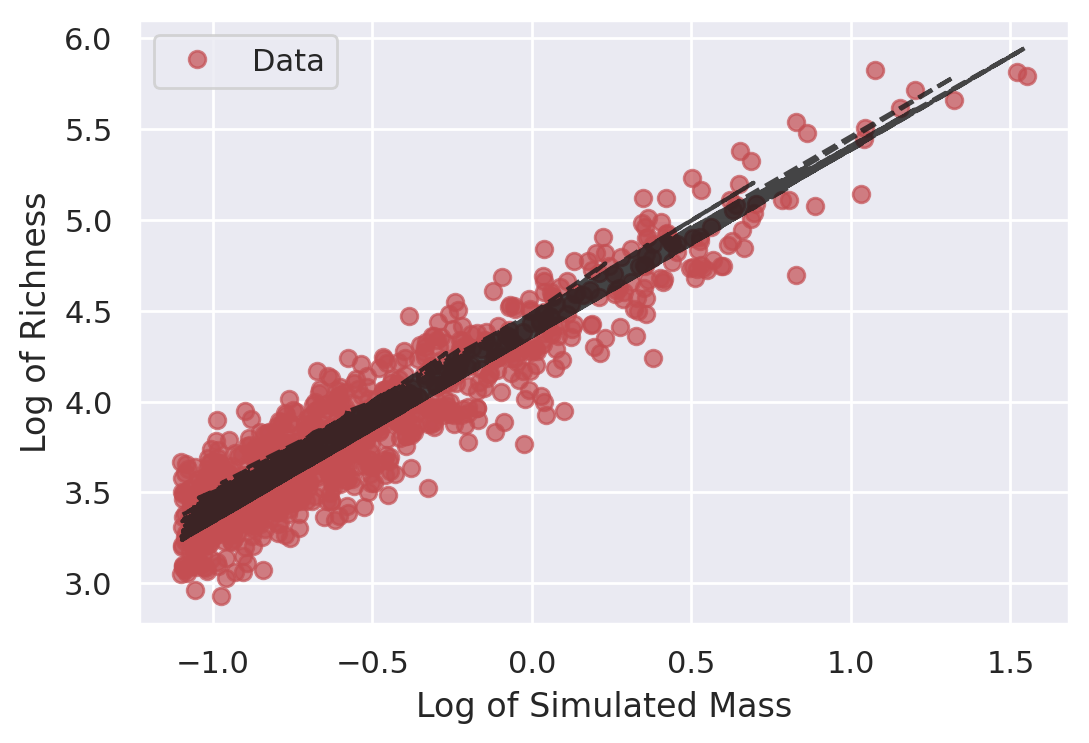

In [11]:
log_msims = np.log(msims/M0)

x1 = log_msims
y1 = ln_lambda

f=lambda x,a,b: a*x + b
fit=curve_fit(f, x1, y1)
xsmooth=np.linspace(np.min(x1), np.max(x1), 1000)
plt.plot(x1,y1,'ro',label='Data', alpha = 0.7)
#plt.plot(xsmooth,f(xsmooth,*fit[0]),'b-',linewidth=2,label='Logarithmic Fit')
plt.xlabel('Log of Simulated Mass')
plt.ylabel('Log of Richness')
plt.legend()

# Unlike the 1-D plot above (simple straight line), this is a vector that
# will create a slope which matches the log value from the previously
# calculated log of lambda based on the true parameter values
# found in (Grandis et al. 2021)

# Meant to compare with the simple 1-D plot above and display
# whether the simulated data is following the trend set by the real parameter values

plt.plot(x1, ln_lambda_true, 'k--', label='Truth', alpha = 0.8)

print('Combination of Slope and Y-Intercept:', fit[0])
print('Slope:', fit[0][0])
print('Y-Intercept:', fit[0][1])

Combination of Slope and Y-Intercept: [1.48253902 1.71750371]
Slope: 1.4825390197288384
Y-Intercept: 1.7175037139592273


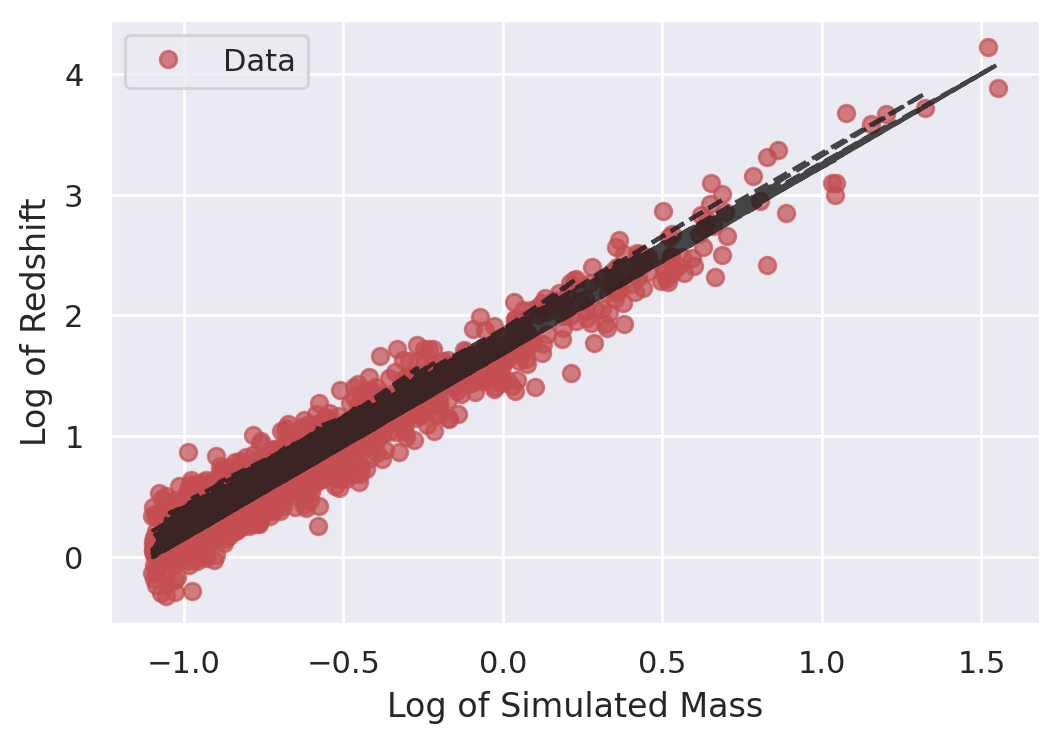

In [12]:
x2 = log_msims
y2 = ln_zeta

f=lambda x,a,b: a*x + b
fit=curve_fit(f, x2, y2)
xsmooth=np.linspace(np.min(x2), np.max(x2), 1000)
plt.plot(x2,y2,'ro',label='Data', alpha = 0.7)
#plt.plot(xsmooth,f(xsmooth,*fit[0]),'b-',linewidth=2,label='Logarithmic Fit')
plt.xlabel('Log of Simulated Mass')
plt.ylabel('Log of Redshift')
plt.legend()


# Unlike the 1-D plot above (simple straight line), this is a vector that
# will create a slope which matches the log value from the previously
# calculated log of zeta based on the true parameter values
# found in (Grandis et al. 2021)

# Meant to compare with the simple 1-D plot above and display
# whether the simulated data is following the trend set by the real parameter values

plt.plot(x1, ln_zeta_true, 'k--', label='Truth', alpha = 0.8)

print('Combination of Slope and Y-Intercept:', fit[0])
print('Slope:', fit[0][0])
print('Y-Intercept:', fit[0][1])

In [13]:
out = dict()
out['z'] = zsims
out['M'] = msims
out['lambda'] = np.exp(ln_lambda)
out['zeta'] = np.exp(ln_zeta)
out['lambda_true'] = np.exp(ln_lambda_true)
out['zeta_true'] = np.exp(ln_zeta_true)

df = pd.DataFrame(out, columns = ['z', 'M', 'lambda', 'zeta', 'lambda_true', 'zeta_true'])
print(df)

#df.to_csv('fake_data_Jun21.csv', index=False)
# pd.DataFrame.to_csv('fake_data_Jun21.csv')

            z             M      lambda       zeta  lambda_true  zeta_true
0    0.557689  1.474454e+14   42.234788   2.351907    40.566543   2.019655
1    0.485329  1.131121e+14   38.924879   1.693837    30.582936   1.318982
2    0.465851  4.285547e+14  134.545489  11.049936   118.615372  10.125121
3    0.171870  1.317897e+14   35.945146   1.809496    34.015610   1.540206
4    0.676519  1.098903e+14   31.455402   1.318885    30.667517   1.328728
..        ...           ...         ...        ...          ...        ...
995  0.154904  1.211686e+14   36.432124   1.520771    31.145056   1.348617
996  0.200567  1.374558e+15  335.032298  68.385693   373.387759  56.567168
997  0.284755  2.992108e+14   71.822632   4.233357    79.854643   5.568036
998  0.298685  3.152079e+14   83.504634   5.087760    84.395239   6.052252
999  0.107514  1.073508e+14   24.876035   1.168526    27.342798   1.108047

[1000 rows x 6 columns]


In [14]:
df0 = df.copy()

display(df0)

,z,M,lambda,zeta,lambda_true,zeta_true
0,0.557689,1.474454e+14,42.234788,2.351907,40.566543,2.019655
1,0.485329,1.131121e+14,38.924879,1.693837,30.582936,1.318982
2,0.465851,4.285547e+14,134.545489,11.049936,118.615372,10.125121
3,0.171870,1.317897e+14,35.945146,1.809496,34.015610,1.540206
4,0.676519,1.098903e+14,31.455402,1.318885,30.667517,1.328728
...,...,...,...,...,...,...
995,0.154904,1.211686e+14,36.432124,1.520771,31.145056,1.348617
996,0.200567,1.374558e+15,335.032298,68.385693,373.387759,56.567168
997,0.284755,2.992108e+14,71.822632,4.233357,79.854643,5.568036
998,0.298685,3.152079e+14,83.504634,5.087760,84.395239,6.052252


In [15]:
zeta = df0.zeta.to_numpy()
zetacut = zeta > 5
df = df0.loc[zetacut].copy()

display(df)

,z,M,lambda,zeta,lambda_true,zeta_true
2,0.465851,4.285547e+14,134.545489,11.049936,118.615372,10.125121
10,0.280736,3.420145e+14,83.667811,7.862994,91.465464,6.828757
11,0.747177,3.940300e+14,102.074530,9.689905,114.170045,9.605146
20,0.205020,8.523379e+14,245.858823,22.131006,229.480324,27.204583
25,0.151939,5.838984e+14,127.219503,10.153594,154.813993,15.039484
...,...,...,...,...,...,...
979,0.649813,2.795207e+14,92.134519,7.318906,79.117690,5.523913
983,0.343081,5.615477e+14,132.395724,13.059771,153.170809,14.843045
994,0.177455,4.181899e+14,90.037276,7.541456,110.548861,9.066412
996,0.200567,1.374558e+15,335.032298,68.385693,373.387759,56.567168


In [16]:
df.to_csv(r'C:\MuStar_Project\mustar-summar-project\simple_model\fake_data_Jun21.csv', index=False)

# Creating an MCMC Model

Using the Simple Model Likelihood in order to see how accurate the predicted MCMC values are from the known true values

In [17]:
SZ_Priors = {'A_sze':[5.24, 0.85], 'B_sze':[1.534, 0.100],'C_sze':[0.465, 0.407],
             'scatter_sze':[0.161, 0.080]}

sz_theta_values = ['A_sze', 'B_sze', 'C_sze', 'scatter_sze']

#Lambda_Priors = {'A_lambda':[76.9, 8.2], 'B_lambda':[1.020, 0.080],'C_lambda':[0.23, 0.16],
#             'scatter_lambda':[0.23, 0.16]}

Lambda_Priors = {'A_lambda':[76.9, 8.2], 'B_lambda':[1.020, 0.080],'C_lambda':[0.23, 0.16],
             'scatter_lambda':[0.23, 0.169]}

lambda_theta_values = ['A_lambda', 'B_lambda', 'C_lambda', 'scatter_lambda']

## new measurements based off of the values written above (sigma_chisi and sigma_lambda) ##

In [18]:
display(df)

,z,M,lambda,zeta,lambda_true,zeta_true
2,0.465851,4.285547e+14,134.545489,11.049936,118.615372,10.125121
10,0.280736,3.420145e+14,83.667811,7.862994,91.465464,6.828757
11,0.747177,3.940300e+14,102.074530,9.689905,114.170045,9.605146
20,0.205020,8.523379e+14,245.858823,22.131006,229.480324,27.204583
25,0.151939,5.838984e+14,127.219503,10.153594,154.813993,15.039484
...,...,...,...,...,...,...
979,0.649813,2.795207e+14,92.134519,7.318906,79.117690,5.523913
983,0.343081,5.615477e+14,132.395724,13.059771,153.170809,14.843045
994,0.177455,4.181899e+14,90.037276,7.541456,110.548861,9.066412
996,0.200567,1.374558e+15,335.032298,68.385693,373.387759,56.567168


In [19]:
ix = np.where((np.array(df['lambda']))>5)[0] # take 100 points
Np = ix.size

yerr = 0.05*np.ones_like(zsims)

redshift = (np.array(df['z']))[ix]
#print("This is the redshift:", redshift)
sz_signal = (np.array(df['zeta']))[ix]
#print("This is the sz_signal:", sz_signal)
_lambda = (np.array(df['lambda']))[ix]
#print("This is the _lambda:", _lambda)
#_lambda_error = (np.array(yerr))[ix]
#print("This is the _lambda_error:", _lambda_error)
mass = np.array(df['M'])[ix]
#print("This is the mass:", mass)

In [20]:
# for a given cluster, i.e. a vector (lbd_hat_i, chisi_i, z_i)
# ix = np.arange(len(lambda_chisq))[lambda_chisq>0][np.argmin(sz_signal[lambda_chisq>0])]
ix = np.arange(len(np.array(df['lambda'])))[(np.array(df['lambda']))>0][np.argmax(np.array(df['lambda'])[np.array(df['lambda'])>0])]

redshift_i = (np.array(df['z']))[ix]
print("This is the redshift_i:", redshift_i)
sz_signal_i = (np.array(df['zeta']))[ix]
print("This is the sz_signal_i:", sz_signal_i)
_lambda_i = (np.array(df['lambda']))[ix]
print("This is the _lambda_i:", _lambda_i)
#_lambda_error_i = (np.array(yerr))[ix]
#print("This is the _lambda_error_i:", _lambda_error_i)

This is the redshift_i: 0.28666470953825307
This is the sz_signal_i: 39.529866095937734
This is the _lambda_i: 339.84630277777063


In [21]:
#x = np.array([df['M'], df['z']])
#print("This is the combined x1 array of mass and redshift:", x1)
x = np.vstack([mass, redshift])
#print("This is the combined x vector of mass and redshift:", x)
y = np.vstack([_lambda, sz_signal])
#print("This is the combined y vector of lambda and zeta:", y)

In [22]:
eps = 1e-9
lbd = _lambda[0]
zeta = sz_signal[0]

print("This is the first value of lambda:", lbd)
print("This is the first value of zeta:", zeta)

theta = [5.24, 1.534, 0.465, 0.161, 76.9, 1.02, 0.29, 0.16, 0.8]

This is the first value of lambda: 134.545488820954
This is the first value of zeta: 11.04993587412156


(array([10., 21., 45., 38., 28., 15.,  6.,  5.,  2.,  2.]),
 array([14.30939497, 14.39353326, 14.47767155, 14.56180984, 14.64594813,
        14.73008642, 14.81422471, 14.898363  , 14.98250129, 15.06663957,
        15.15077786]),
 <BarContainer object of 10 artists>)

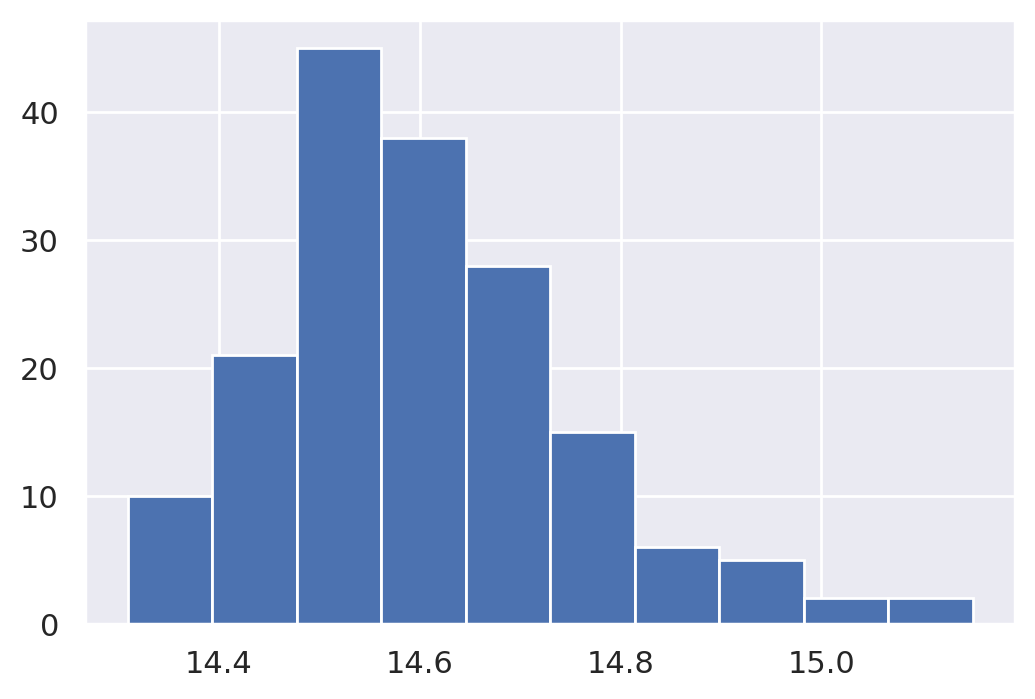

In [23]:
plt.hist(np.log10(df['M'][np.array(df['lambda'])>20]))

In [24]:
# set up integration vectors
# mvec = np.logspace(13.8, 15.5, 75)
# lbdvec = np.linspace(3,1.2*np.max(lambda_chisq),150)
# zetavec = np.linspace(1,1.1*np.max(sz_signal),75)

lbdvec = np.linspace(3, 1.2*np.max(np.array(df['lambda'])), 150)
zetavec = np.linspace(1, 1.1*np.max(np.array(df['zeta'])), 75)

print('Vector size')
print(lbdvec.size)
print(zetavec.size)

Vector size
150
75


In [25]:
zvec = np.linspace(np.min(np.array(df['z'])), np.max(np.array(df['z'])), 100)
#zvec = np.linspace(np.min(redshift), np.max(redshift), 100)
## zzv, mm = np.meshgrid(zvec, mvec)
zzv= np.meshgrid(zvec)
from scipy import interpolate

In [26]:
def slice_array(y,alpha=1e-2):
    cy = np.cumsum(y/np.sum(y),axis=0)
    ilo,iup = np.interp([alpha,1-alpha],cy,np.arange(len(y))).astype(int)+(0,2)
    return ilo, iup

In [27]:
def prob_chisi(zeta, sz_signal, eps=1e-12):
    res = np.exp(-(sz_signal-np.sqrt(zeta**2+2))**2/2.)/np.sqrt(2*np.pi)
    return res#np.where(res<eps,0.,res)

def gaussian(x,mu,std):
    return np.exp(-(x-mu)**2/std**2/2.)/np.sqrt(2*np.pi*std**2)

#def prob_lbd_hat(lbd, _lambda , yerr, eps=1e-12):
#    res = gaussian(lbd, _lambda, yerr)
#   return res#np.where(res<eps,0.,res)

def prob_lbd_hat(lbd, _lambda , eps=1e-12):
    res = gaussian(lbd, _lambda, 1)
    return res#np.where(res<eps,0.,res)

### IF THE STD IS TOO SMALL prob_lambda_hat_vec becomes all 0s


In [28]:
alpha = 0.1

prob_lbd_hat_vec = np.array([prob_lbd_hat(lbdvec, _lambda_i)
                             for _lambda_i in zip(_lambda)])
print(prob_lbd_hat_vec.shape)
print("This is prob_lbd_hat_vec:", prob_lbd_hat_vec)

prob_chisi_vec = np.array([prob_chisi(zetavec, sz_signal_i) for sz_signal_i in sz_signal])
print(prob_chisi_vec.shape)
print("This is prob_chisi_vec:", prob_chisi_vec)

lbd_indices_vec = np.array([slice_array(pi, alpha=alpha) for pi in prob_lbd_hat_vec])
print(lbd_indices_vec.shape)
#print("This is lbd_indices_vec:", lbd_indices_vec)

zeta_indices_vec = np.array([slice_array(pi, alpha=alpha) for pi in prob_chisi_vec])
print(zeta_indices_vec.shape)
#print("This is zeta_indices_vec:", zeta_indices_vec)

(172, 150)
This is prob_lbd_hat_vec: [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(172, 75)
This is prob_chisi_vec: [[5.59163801e-20 3.53408676e-17 4.29560899e-14 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [2.74585768e-09 1.74986265e-07 1.32865123e-05 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [7.07181056e-15 1.67899244e-12 6.24946170e-10 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.87226348e-08 9.46591168e-07 5.43326177e-05 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 3.17058426e-06
  1.48628368e-08 2.54846944e-11]
 [1.43107515e-03 1.23679655e-02 8.39359926e-02 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]
(172, 2)
(172, 2)


In [29]:
from scipy.integrate import simps

# given: mvec, lbdvec and zetavec

zz, ll = np.meshgrid(zetavec, lbdvec, indexing='ij')

def log_likelihood_vec2(theta, indices, eps=1e-9):
    # defining variables
    probs = []
    for ix in indices:
        probs.append(_log_likelihood2(theta, ix))
    p = np.array(probs)/np.sum(probs)
    log_p = np.log(p)
    log_p = np.where(np.isnan(log_p), -np.inf, log_p)
    return np.sum(log_p)

In [30]:
def _log_likelihood2(theta, ix):
    # unfolding theta
    A_lambda, B_lambda, C_lambda, scatter_lambda = theta[4:8]
    A_sze, B_sze, C_sze, scatter_sze = theta[:4]
    rho = theta[-1]
    
    redshift_i = redshift[ix]
    #print("This is redshift:", redshift_i)
    p_chisi = prob_chisi_vec[ix]
    #print("This is p_chisi:", p_chisi)
    p_lbd_hat = prob_lbd_hat_vec[ix]
    #print("This is p_lbd_hat:", p_lbd_hat)
    llo, lup = list(lbd_indices_vec[ix])
    #print("This is the list of lbd_indices_vec[ix]:", lbd_indices_vec[ix])
    clo, cup = list(zeta_indices_vec[ix])
    #print("This is the list of zeta_indices_vec[ix]:", zeta_indices_vec[ix])
    
    #print("This is llo:", llo)
    #print("This is lup:", lup)
    
    #print("This is clo:", clo)
    #print("This is cup:", cup)
    #halo_mass_func = hmf_vector[ix]

    # calling predictions;
    ln_lbd_pred = ln_lbd_given_M([A_lambda, B_lambda, C_lambda, scatter_lambda], mass, redshift_i)
    #print("This is ln_lbd_pred before lup,llo,cup,clo:", ln_lbd_pred)
    ln_zeta_pred= ln_zeta_given_M([A_sze, B_sze, C_sze, scatter_sze], mass, redshift_i)
    #print("This is ln_zeta_pred before lup,llo,cup,clo:", ln_zeta_pred)
    
    #hmf = np.tile(halo_mass_func, (int(lup-llo), int(cup-clo), 1)).T
    ln_lbd_pred = np.tile(ln_lbd_pred, (int(lup-llo), int(cup-clo), 1)).T
    #print("This is ln_lbd_pred after lup,llo,cup,clo:", ln_lbd_pred)
    ln_zeta_pred = np.tile(ln_zeta_pred, (int(lup-llo), int(cup-clo), 1)).T
    #print("This is ln_zeta_pred after lup,llo,cup,clo:", ln_zeta_pred)
    
    # compute dn_dlbd_dzeta_integrand
    # Now p_lbd_zeta instead of p_total_m = compute_dn_dlbd_dzeta_vec2
    p_lbd_zeta = compute_dn_dlbd_dzeta_vec2(_lambda_i, sz_signal_i,
                                           scatter_lambda, scatter_sze, rho,
                                           ll[clo:cup,llo:lup],zz[clo:cup,llo:lup],
                                           ln_lbd_pred, ln_zeta_pred)
    
    print("This is p_lbd_zeta:", p_lbd_zeta)
    
    # integrate over M
    # Comment out integeration!
    # p_lbd_zeta = np.trapz(p_total_m, x=mvec, axis=0)

    # integrate over zeta
    p_chisi = np.tile(p_chisi[clo:cup], (int(lup-llo), 1)).T
    #print("This is p_chisi:", p_chisi)
    
    p_lbd = np.trapz(p_lbd_zeta*p_chisi, x=zetavec[clo:cup], axis=0)
    #print("This is p_lbd after trapezoidal transformation:", p_lbd)

    # integrate over lambda
    p = np.trapz(p_lbd*p_lbd_hat[llo:lup], x=lbdvec[llo:lup], axis=0)
    #print("This is p after trapezoidal transformation:", p)
    return p

In [31]:
def compute_dn_dlbd_dzeta_vec2(_lambda_i, sz_signal_i, scatter_lambda, scatter_sze, rho,
                               lvec, zvec, ln_lbd_pred, ln_zeta_pred, eps = 1e-9):
    
    # converting std to normal distribution
    s_zeta = logNormal_variance(ln_zeta_pred, scatter_sze)
    print("This is ln_zeta_pred (1):", ln_zeta_pred)
    print("This is scatter_sze (2):", scatter_sze)
    print("This is s_zeta (3):", s_zeta)
    s_lambda = logNormal_variance(ln_lbd_pred, scatter_lambda)
    print("This is ln_lbd_pred (1):", ln_lbd_pred)
    print("This is scatter_lambda (2):", scatter_lambda)
    print("This is s_lambda (3):", s_lambda)
    s_zeta_inv = np.where(scatter_sze<=s_zeta, -np.inf, 1/s_zeta)
    # If the value of s_zeta is greater than 0.161, the point should be equal to neg infinity
    print("This is s_zeta_inv:", s_zeta_inv)
    s_lambda_inv = np.where(s_lambda<=eps, -np.inf, 1/s_lambda)
    # If the value of eps is greater than s_lambda, the point should be equal to neg infinity
    print("This is s_lambda_inv:", s_lambda_inv)
    
    cov = (scatter_lambda)**(2)*(scatter_sze)**(2)*(1-rho**2)
    print("This is cov matrix:", cov)
    additional_cov = (-0.5)*np.log(np.pi*cov**2)
    print("This is additional_cov:", additional_cov)
    
    # avoid error messages
    rho_inv = (1-rho**2)
    print("This is rho_inv pt1:", rho_inv)
    rho_inv = np.where(rho_inv<=eps, -np.inf, 1/rho_inv)
    print("This is rho_inv pt2:", rho_inv)
    
    # defining standardized variables
    #lbd_std1 = (np.log(lvec) - (ln_lbd_pred))
    #lbd_std = lbd_std1.dot(s_lambda_inv)
    #zeta_std1 = (np.log(zvec)- (ln_zeta_pred))
    #zeta_std = zeta_std1.dot(s_zeta_inv)
    
    lbd_std = (np.log(lvec) - (ln_lbd_pred))*s_lambda_inv
    print("This is lbd_std:", lbd_std)
    zeta_std = (np.log(zvec)- (ln_zeta_pred))*s_zeta_inv
    print("This is zeta_std:", zeta_std)
    np.seterr(invalid='ignore')

    # lbd_likelihood
    lp_lbd  = (-rho_inv*lbd_std**2)/2
    print("This is lp_lbd:", lp_lbd)

    # zeta likelihood
    lp_zeta = (-rho_inv*zeta_std**2)/2
    print("This is lp_zeta:", lp_zeta)

    # corr likelihod
    lp_corr = rho*rho_inv*lbd_std*zeta_std
    print("This is lp_corr:", lp_corr)

    lp_total_m = lp_lbd + lp_zeta + lp_corr + additional_cov
    print("This is lp_total_m:", lp_total_m)
    
    p_total_m = (np.exp(lp_total_m))/(lvec*zvec)
    print("This is p_total_m:", p_total_m)
    
    return p_total_m

In [32]:
rho = theta[-1]
scatter_sze = theta[3]
scatter_lambda = theta[7]


def set_gaussian_prior(param, mu, sigma):
    return -0.5*((param - mu)/(sigma))**2

# Setting SZE priors
def set_prior_sze(theta_values):
    lp = 0.
    rhomin = 0.
    rhomax = 1.
    
    for i, prior_name in enumerate(['A_sze', 'B_sze', 'C_sze', 'scatter_sze']):
        mean, error = SZ_Priors[prior_name]
        param = theta_values[i]
        result = set_gaussian_prior(param, mean, error)
        lp += np.where(np.abs(result)>9., -np.inf, result)
        # outside a range of six sigmas (six standard deviations)
    # set prior to 1 (log prior to 0) if in the range and zero (-inf) outside the range 
    lp = 0. if (theta_values[-1] > 0) else -np.inf
    return lp

# Setting Lambda priors
def set_prior_lambda(theta_values):
    lp = 0.
    rhomin = 0.
    rhomax = 1.
    
    for i, prior_name in enumerate(['A_lambda', 'B_lambda', 'C_lambda', 'scatter_lambda']):
        mean, error = Lambda_Priors[prior_name]
        param = theta_values[i]
        result = set_gaussian_prior(param, mean, error)
        lp += np.where(np.abs(result)>9., -np.inf, result)
        # outside a range of six sigmas (six standard deviations)
       
    # set prior to 1 (log prior to 0) if in the range and zero (-inf) outside the range 
    lp = 0. if (theta_values[-1] > 0) else -np.inf
    return lp

def logprior(theta):
    lp = 0
    
    A_lambda, B_lambda, C_lambda, scatter_lambda = theta[4:8]
    A_sze, B_sze, C_sze, scatter_sze = theta[:4]
    rho = theta[-1]
    
    lp_lambda = set_prior_lambda([A_lambda, B_lambda, C_lambda, scatter_lambda])
    lp_sze = set_prior_sze([A_sze, B_sze, C_sze, scatter_sze])
    
    lp = 0. if ((rho > 0) and (rho < 1)) else -np.inf
    return lp + lp_lambda + lp_sze

In [33]:
logprior(theta)

0.0

In [34]:
def logposterior(theta, indices):
    lp = logprior(theta)
    
    # if the prior is not finite return a probability of zero (log probability of -inf)
    if not np.isfinite(lp):
        return -np.inf
    
    # return the likeihood times the prior (log likelihood plus the log prior)
    return lp + log_likelihood_vec2(theta, indices, eps=1e-9)

In [35]:
#set_prior_sze([5.24, 1.534, 0.465, 0.161])

In [36]:
Nburnin = 600 # number of burn-in samples
Nsamples = 1800 # number of final posterior samples
walkers = 100
ndims = len(theta)
guess = (np.array(theta)[:, np.newaxis]*(1.+0.01*np.random.normal(size=(ndims,walkers)))).T

# set additional args for the posterior (the data, the noise std. dev., and the abscissa)
sel = np.arange(len(redshift))#[:100]
sel = np.random.randint(len(redshift), size=100, dtype=int)
argslist = [sel]


def is_broadcastable(shp1, shp2):
    for a, b in zip(shp1[::-1], shp2[::-1]):
        if a == 1 or b == 1 or a == b:
            pass
        else:
            return False
    return True

is_broadcastable((2,0),(1000,2,2))

False

In [37]:
logposterior(theta, sel)

This is ln_zeta_pred (1): [[[2.25883675 2.25883675]
  [2.25883675 2.25883675]
  [2.25883675 2.25883675]
  [2.25883675 2.25883675]]

 [[1.91281981 1.91281981]
  [1.91281981 1.91281981]
  [1.91281981 1.91281981]
  [1.91281981 1.91281981]]

 [[2.12999426 2.12999426]
  [2.12999426 2.12999426]
  [2.12999426 2.12999426]
  [2.12999426 2.12999426]]

 ...

 [[2.22128022 2.22128022]
  [2.22128022 2.22128022]
  [2.22128022 2.22128022]
  [2.22128022 2.22128022]]

 [[4.04666687 4.04666687]
  [4.04666687 4.04666687]
  [4.04666687 4.04666687]
  [4.04666687 4.04666687]]

 [[1.78761373 1.78761373]
  [1.78761373 1.78761373]
  [1.78761373 1.78761373]
  [1.78761373 1.78761373]]]
This is scatter_sze (2): 0.161
This is s_zeta (3): [[[ 2.46916778  2.46916778]
  [ 2.46916778  2.46916778]
  [ 2.46916778  2.46916778]
  [ 2.46916778  2.46916778]]

 [[ 1.23595912  1.23595912]
  [ 1.23595912  1.23595912]
  [ 1.23595912  1.23595912]
  [ 1.23595912  1.23595912]]

 [[ 1.90826832  1.90826832]
  [ 1.90826832  1.9082683

ValueError: operands could not be broadcast together with shapes (3,1,1) (171,4,2) 

In [ ]:
from scipy.optimize import minimize

np.random.seed(42)
nll = lambda *args: -log_likelihood_vec2(*args)
initial = theta + 0.1 * np.random.randn(9)
soln = minimize(nll, initial, args=sel)
albd, blbd, clbd, slbd, rho = soln.x[4:]

print("Maximum likelihood estimates:")
print("Albd = {0:.3f}".format(albd))
print("Blbd = {0:.3f}".format(blbd))
print("Clbd = {0:.3f}".format(clbd))
print("Scatter_lbd = {0:.3f}".format(slbd))
print("rho: {0:.3f}".format(rho))

In [ ]:
theta

In [ ]:
soln.x[-1]

In [ ]:
import time
from multiprocessing import Pool
with Pool(processes = 16) as pool:
    sampler = emcee.EnsembleSampler(walkers, ndims, logposterior,args=argslist, pool=pool)
    start = time.time()
    sampler.run_mcmc(guess, Nsamples+Nburnin, progress=True)
    end = time.time()
    multi_time = end - start
    serial_time = (1.5)*(3600)
    print("Multiprocessing took {0:.1f} seconds".format(multi_time))
    print("{0:.1f} times faster than serial".format(serial_time / multi_time))